In [15]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import yfinance as yf
#plt.style.use('fivethirtyeight')
#np.random.seed(777)
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [16]:
rics = ['SGEN', 'URI', 'WYNN', 'GEHC', 'LVS', 'STLD', 'BWA', 'ACGL', 'LW', 'RE']     

In [17]:
data = yf.download(rics, start='2010-01-01')['Adj Close']
data = data.dropna()
data.head()

[*********************100%***********************]  10 of 10 completed


,ACGL,BWA,GEHC,LVS,LW,RE,SGEN,STLD,URI,WYNN
Date,,,,,,,,,,
2022-12-15,60.750000,40.651756,60.000000,48.650002,85.907814,321.006439,128.410004,101.573090,356.264709,84.949997
2022-12-16,61.029999,40.402603,56.740002,47.490002,86.745445,321.623566,129.610001,100.676155,352.357483,86.010002
2022-12-19,60.540001,40.482330,56.500000,46.360001,86.865112,320.896942,127.629997,101.194389,350.104858,81.559998
2022-12-20,62.240002,40.322872,57.209999,46.380001,87.483376,325.505646,133.020004,102.848732,349.466919,82.570000
2022-12-21,63.360001,40.861042,56.959999,46.889999,88.400787,333.687836,132.320007,104.463219,358.656860,82.599998


---

## Randomisation Technique

In [18]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((12,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(data.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        ## Sharpe Ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev   
    return results, weights_record

In [19]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

risk_free_rate = yf.download('^TNX')['Close'][-1] / 100

[*********************100%***********************]  1 of 1 completed


In [22]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [23]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [24]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [26]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(data.columns):
        print(txt,":","Annualised return",round(an_rt[i],2),", Annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('Annualised Volatility')
    ax.set_ylabel('Annualised Returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.09
Annualised Volatility: 0.2


            ACGL  BWA   GEHC  LVS     LW   RE   SGEN  STLD  URI   WYNN
allocation   0.0  0.0  20.97  0.0  31.65  0.0  23.63   0.0  0.0  23.75
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.74
Annualised Volatility: 0.17


            ACGL   BWA   GEHC    LVS     LW     RE  SGEN  STLD  URI  WYNN
allocation   0.0  8.12  19.42  15.02  38.36  10.87  8.21   0.0  0.0   0.0
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

ACGL : Annualised return 0.35 , Annualised volatility: 0.3
BWA : Annualised return 0.53 , Annualised volatility: 0.26
GEHC : Annualised return 0.98 , Annualised volatility: 0.39
LVS : Annualised return 0.54 , Annualised volatility: 0.3

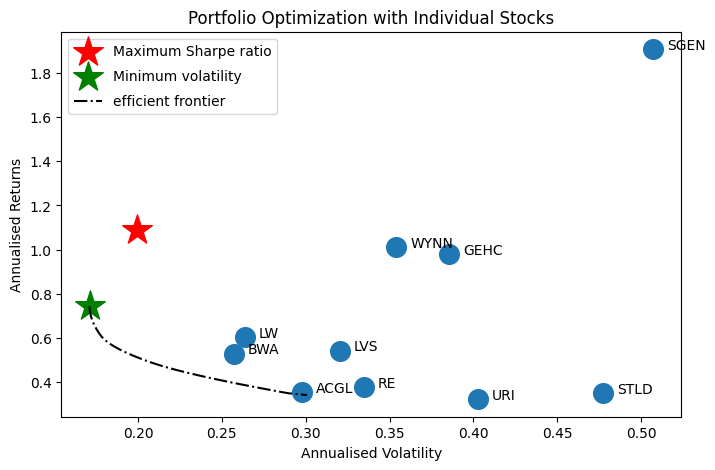

In [27]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)